# Denoising CITE-seq protein data

In this tutorial, we go through steps for CITE-seq protein denoising using scAR. We will use the 10xPBMC5k CITE-seq dataset, which contained about five thousands cells stained with a panel of 32 antibodies. The original dataset was downloaded from [10x genomics dataset](https://www.10xgenomics.com/resources/datasets/5-k-peripheral-blood-mononuclear-cells-pbm-cs-from-a-healthy-donor-with-cell-surface-proteins-v-3-chemistry-3-1-standard-3-1-0), and the processed and annotation data is available at [scAR-reproducibility/data](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data)  
  
  - Run on your own device. You need to install several packages, [Scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) and [scAR](https://github.com/CaibinSh/scAR/blob/main/README.md)
  - Run on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CaibinSh/scAR-reproducibility/blob/main/reproducibility/scAR_tutorial_denoising_CITEseq.ipynb) ****

In [ ]:
# Run this cell to install Scanpy and scAR in Colab
# Skip this cell if running on your own device

!pip install scanpy

!git clone https://github.com/CaibinSh/scAR.git
!pip install scAR/

!git clone https://github.com/CaibinSh/scAR-reproducibility.git
!cd scAR-reproducibility/reproducibility

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import scAR

import warnings
warnings.simplefilter(action='ignore')

In [2]:
from matplotlib import pylab

params = {'legend.fontsize': 7,
          'legend.title_fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (6, 4.5),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'axes.grid':False,}
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=4, trim=True);

<Figure size 432x324 with 0 Axes>

## read data

Cells were annotated using well-established markers, see the [manuscript](https://doi.org/10.1101/2022.01.14.476312) for details. For the tutoring purpose, the processed file ([CITEseq_PBMCs_5k.h5ad](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data/)) is provided.

In [3]:
PBMCs5k = sc.read('../data/CITEseq_PBMCs_5k.h5ad')

visualization of cell types

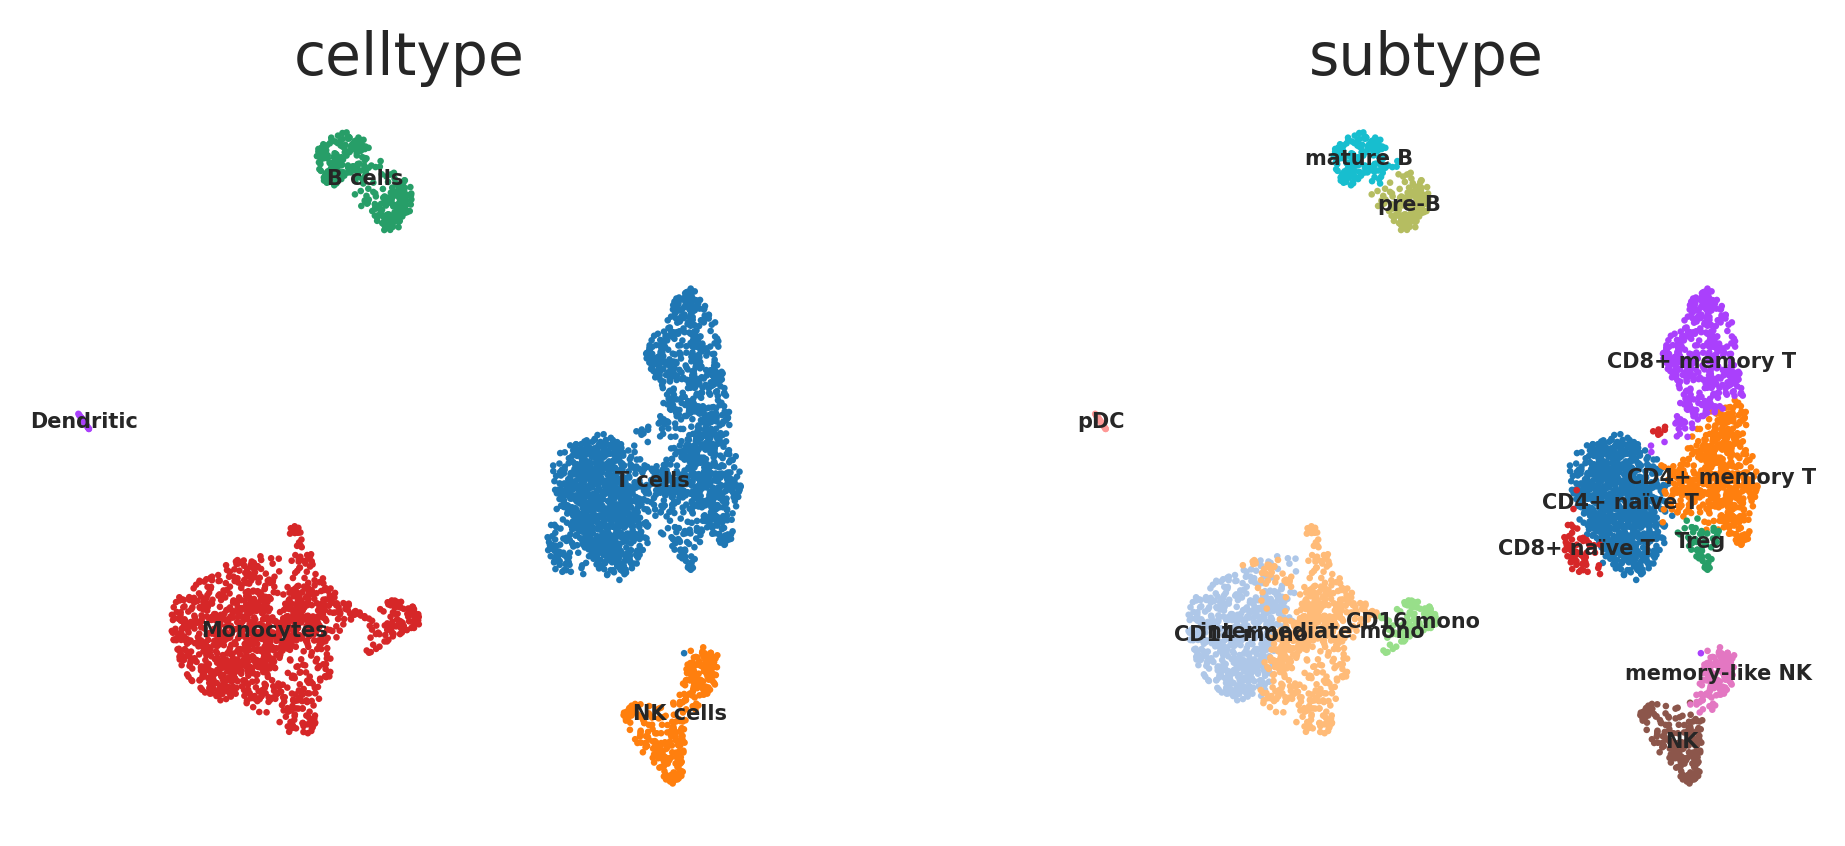

In [4]:
sc.settings.set_figure_params(dpi=150,figsize=(3, 3.1))
sc.pl.umap(PBMCs5k, size=10, color=["celltype", "subtype"],color_map="viridis",legend_loc="on data", frameon=False, legend_fontsize=5)

In [5]:
raw_ADT = PBMCs5k[:, PBMCs5k.var_names.str.endswith('_TotalSeqB')].to_df()
raw_ADT.columns = raw_ADT.columns.str.replace('_TotalSeqB','')

In [18]:
raw_ADT.head()

raw_CD3  raw_CD4  raw_CD8a  raw_CD11b  raw_CD14  raw_CD15  \
CCGGGTAGTTCAAACC-1    876.0    968.0       8.0       10.0       8.0       9.0   
CTTTCGGTCCGCAACG-1    516.0    664.0       4.0        4.0       4.0       6.0   
TCTACCGGTGTAAACA-1    666.0    837.0       5.0       10.0       6.0       5.0   
ATAGACCCATAATGCC-1    352.0    709.0       3.0        7.0       8.0      12.0   
TCTATACAGGGTATAT-1    289.0    861.0       7.0        3.0       8.0       4.0   

                    raw_CD16  raw_CD19  raw_CD20  raw_CD25  ...  raw_CD197  \
CCGGGTAGTTCAAACC-1       1.0       3.0      10.0       3.0  ...       20.0   
CTTTCGGTCCGCAACG-1       0.0       3.0       1.0       2.0  ...       15.0   
TCTACCGGTGTAAACA-1       1.0       4.0       7.0       4.0  ...       30.0   
ATAGACCCATAATGCC-1       3.0       4.0       4.0       2.0  ...       13.0   
TCTATACAGGGTATAT-1       2.0       4.0       9.0      21.0  ...       10.0   

                    raw_CD274  raw_CD278  raw_CD335  raw_PD-1  raw_HLA-DR  \
CCGGGTAGTTCAAACC-1        2.0       29.0        6.0       6.0        14.0   
CTTTCGGTCCGCAACG-1        1.0       26.0        5.0       5.0         8.0   
TCTACCGGTGTAAACA-1        1.0       36.0        2.0       5.0         9.0   
ATAGACCCATAATGCC-1        2.0      100.0        6.0      12.0         9.0   
TCTATACAGGGTATAT-1        3.0       31.0        3.0       3.0        11.0   

                    raw_TIGIT  raw_IgG1_control  raw_IgG2a_control  \
CCGGGTAGTTCAAACC-1        4.0               3.0                3.0   
CTTTCGGTCCGCAACG-1        1.0               1.0                3.0   
TCTACCGGTGTAAACA-1        1.0               3.0                3.0   
ATAGACCCATAATGCC-1        4.0               2.0                2.0   
TCTATACAGGGTATAT-1        1.0               4.0                4.0   

                    raw_IgG2b_control  
CCGGGTAGTTCAAACC-1                2.0  
CTTTCGGTCCGCAACG-1                0.0  
TCTACCGGTGTAAACA-1                2.0  
ATAGACCCATAATGCC-1                2.0  
TCTATACAGGGTATAT-1                4.0  

[5 rows x 32 columns]

**We strongly recommended calculating ambient profile (i.e., the frequencies of ADTs) using cell-free droplets rather than using cells (the default setting of scAR) in the CITEseq mode. Calculation of ambient profile is key to precise cleaning. Averaging pooled cells may show poor performance.**

In [7]:
ambient_profile = PBMCs5k.uns['ambient_profile']

In [17]:
ambient_profile.head()

ambient_profile
CD3           0.049876
CD4           0.048823
CD8a          0.023453
CD11b         0.083170
CD14          0.107178

The index names (ADT names) and column names are not important, but the order of ADTs should be consistent with the order in count matrix (i.e., raw_ADT)

## Train scAR

In [9]:
scarObj = scAR.model(raw_count=raw_ADT.values,
                     empty_profile=ambient_profile.values,  # Providing ambient profile is recommended for CITEseq; in other modes, you can leave this argument as the default value -- None
                     scRNAseq_tech='CITEseq',
                     model='binomial'   # Depending on your data's sparsity, you can choose between 'binomial', 'possion', and 'zeroinflatedpossion'
                    )

scarObj.train(epochs=800,
              batch_size=64,
             )

# After training, we can infer the true protein signal
scarObj.inference()  # by defaut, batch_size=None, set a batch_size if getting GPU memory issue

..Running VAE using the following param set:
......scAR mode:  CITEseq
......count model:  binomial
......num_input_feature:  32
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 800/800 [04:46<00:00,  2.79it/s]
  Inferring .....


In [10]:
denoised_ADT = pd.DataFrame(scarObj.native_counts, index=raw_ADT.index, columns=raw_ADT.columns)
denoised_ADT.columns = denoised_ADT.columns.str.replace('_TotalSeqB', '')

## Check results

### Boxplot of ADT counts per cell type

Visualization of ADT counts per cell type before and after denoising.

In [11]:
raw_ADT_stacked = np.log2(raw_ADT+1).stack().to_frame('log2(counts+1)').rename_axis(['cells', 'ADTs']).reset_index().set_index('cells')   # log scale for visualization,
raw_ADT_stacked = raw_ADT_stacked.join(PBMCs5k.obs) # add cell type information
raw_ADT_stacked['count'] = 'raw'

denoised_ADT_stacked = np.log2(denoised_ADT+1).stack().to_frame('log2(counts+1)').rename_axis(['cells', 'ADTs']).reset_index().set_index('cells')
denoised_ADT_stacked = denoised_ADT_stacked.join(PBMCs5k.obs)
denoised_ADT_stacked['count'] = 'scAR-denoised'

combined_ADTs = raw_ADT_stacked.append(denoised_ADT_stacked)

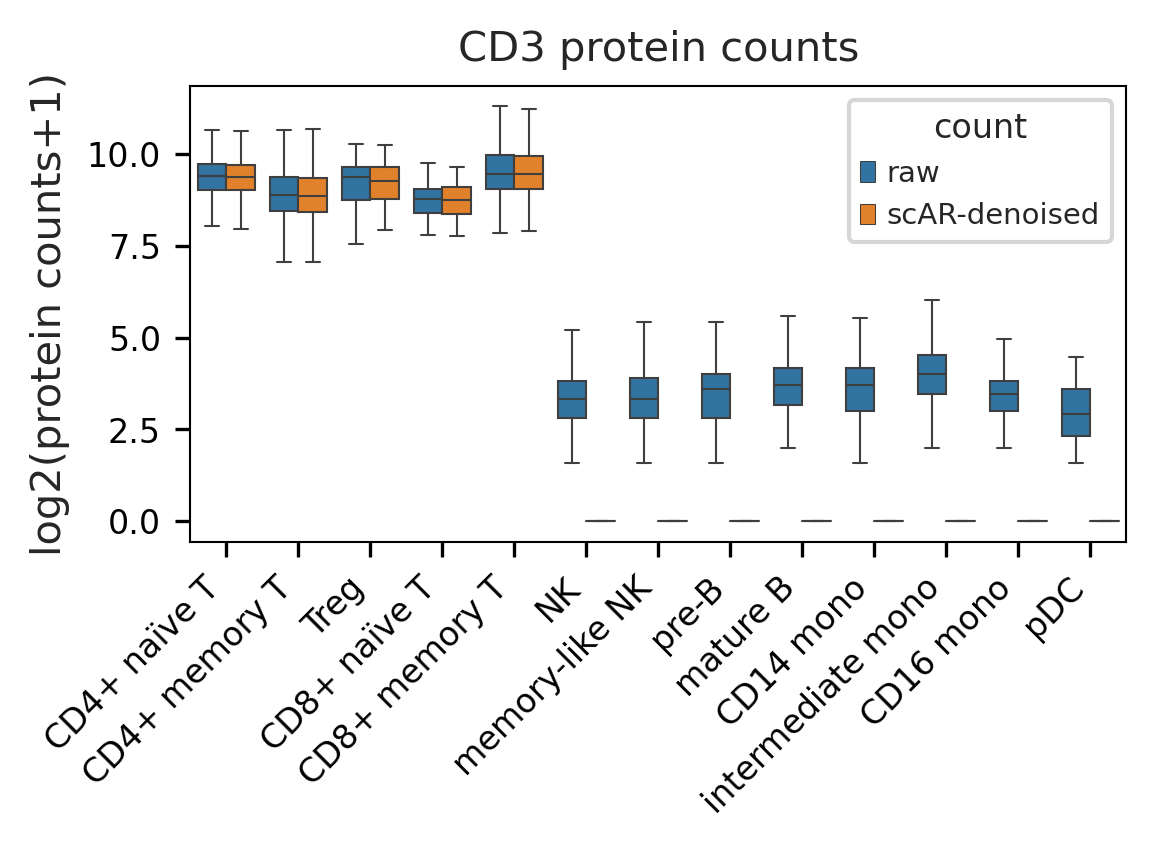

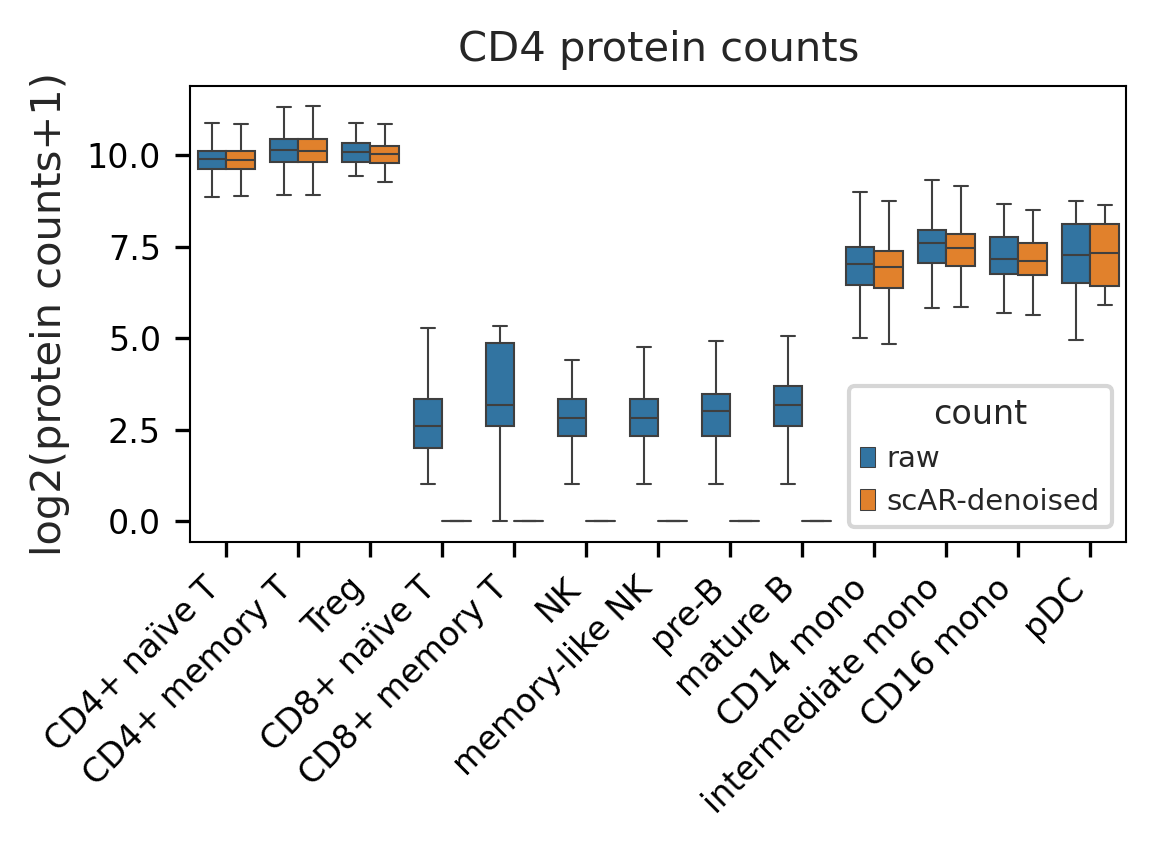

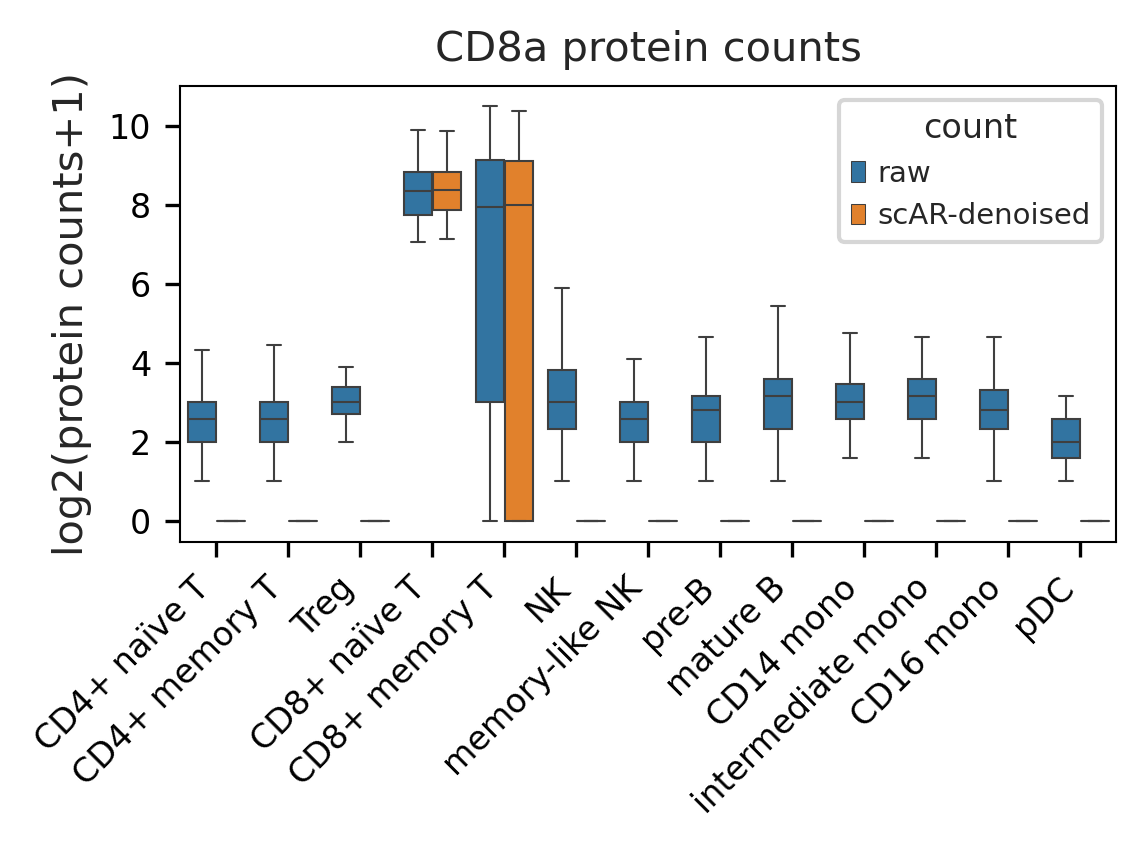

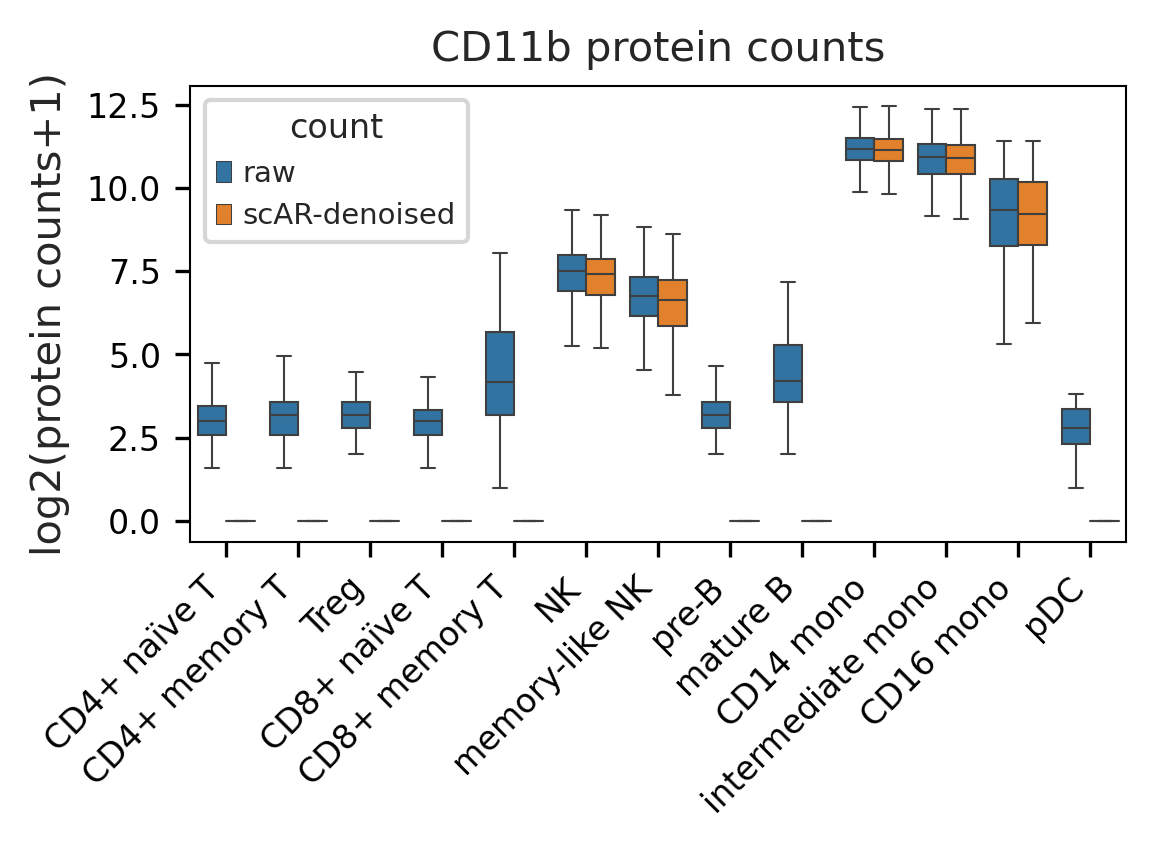

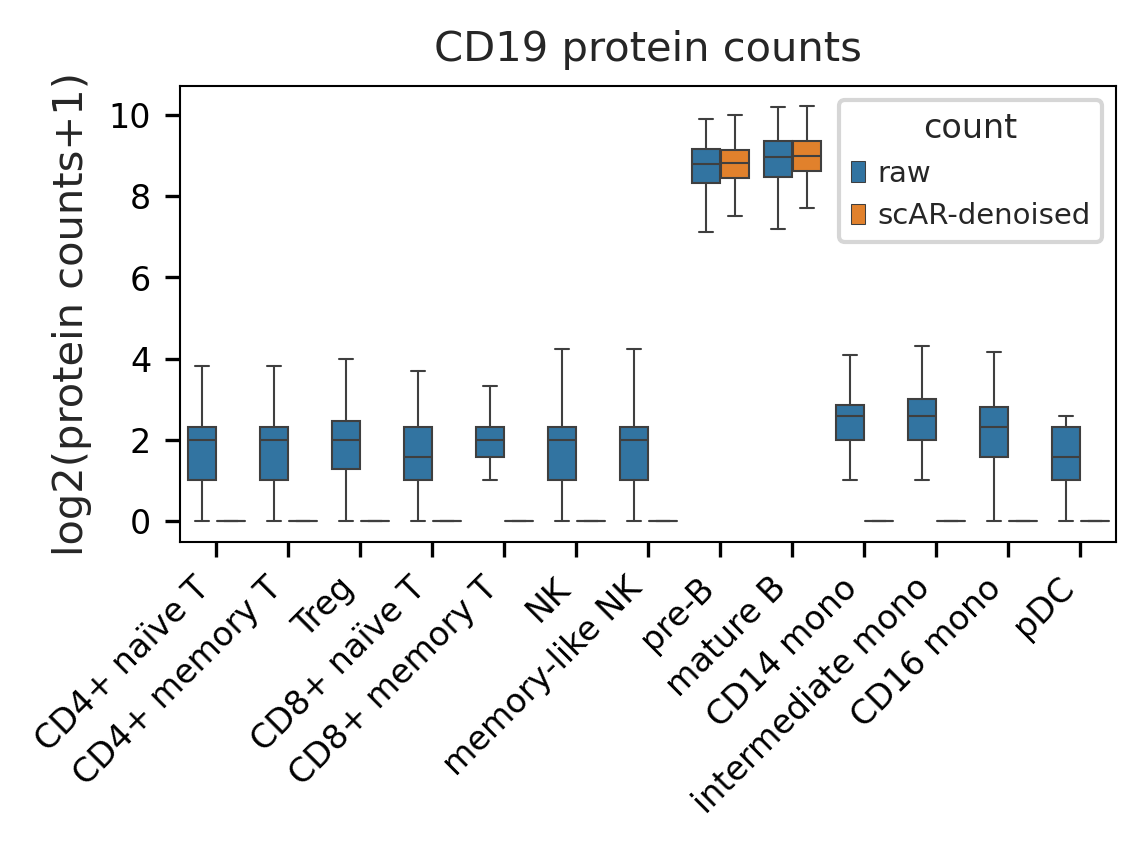

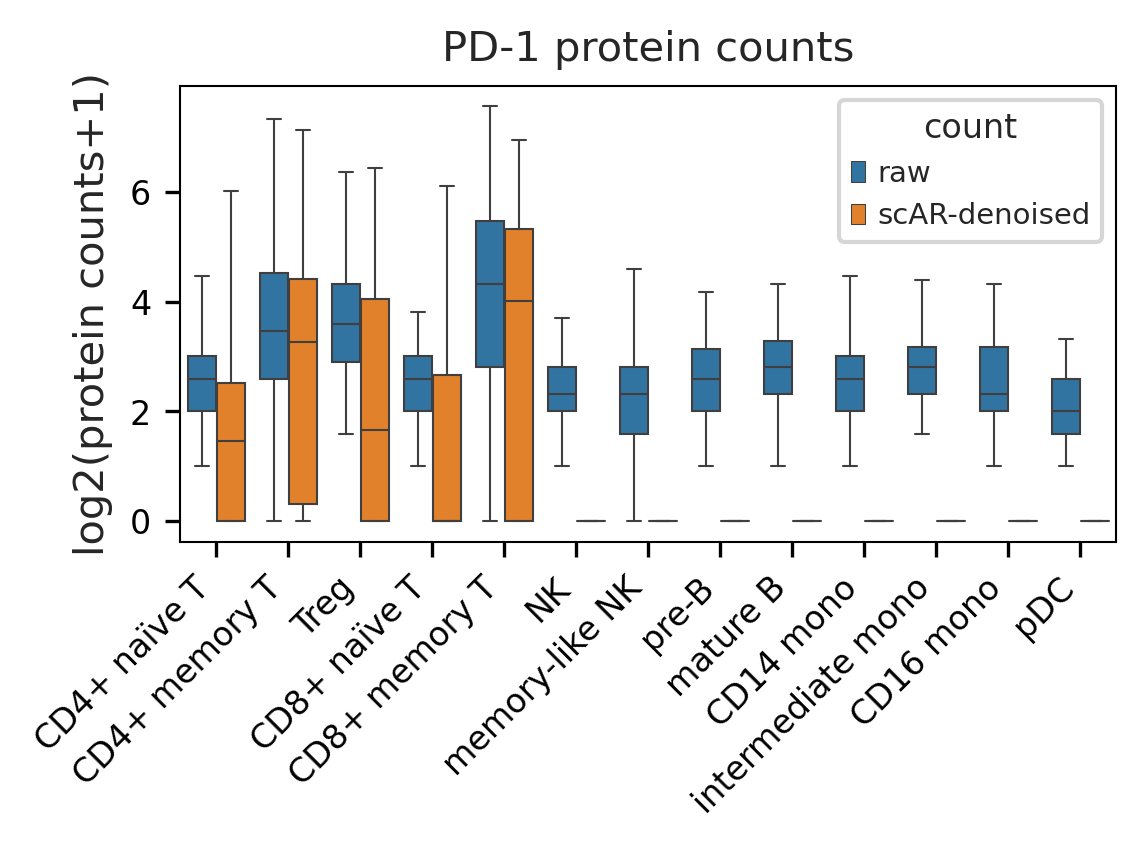

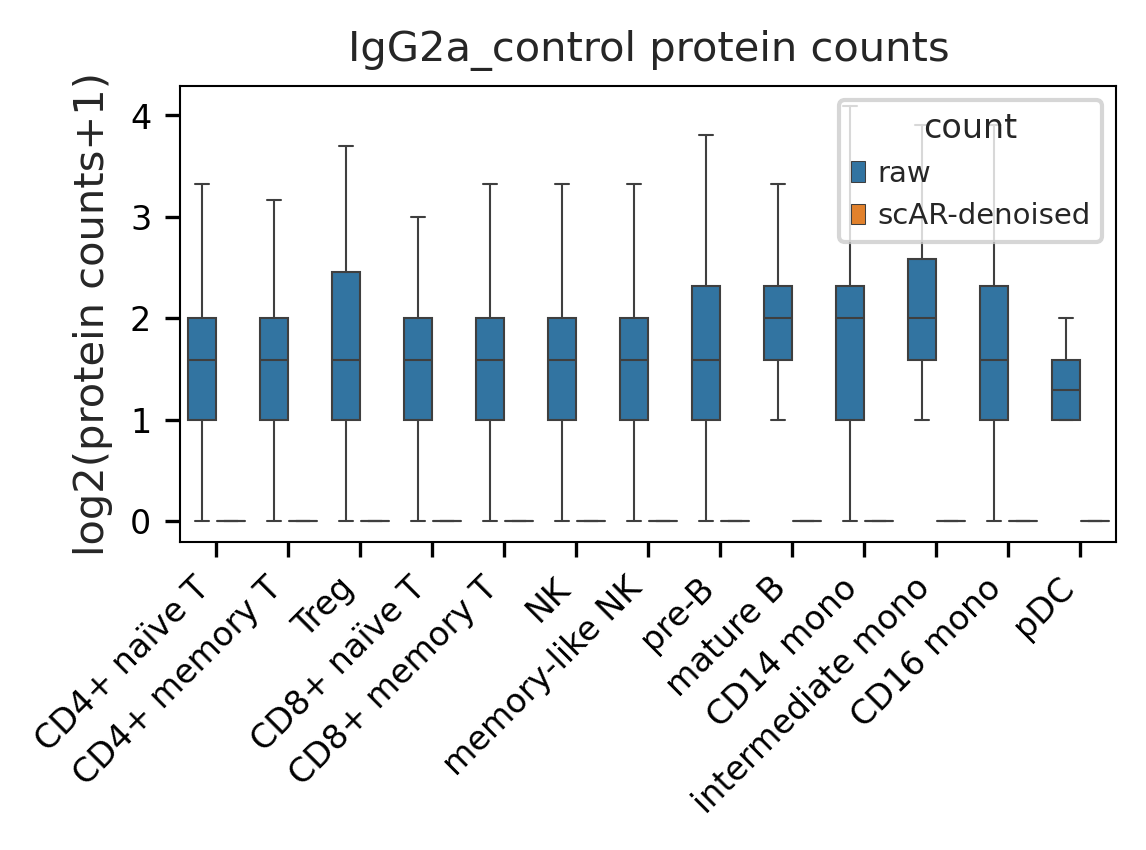

In [12]:
pylab.rcParams.update(params);

# Visualize several markers

for marker in ["CD3", "CD4", "CD8a", "CD11b", "CD19", "PD-1", "IgG2a_control"]:
    tmp = combined_ADTs[combined_ADTs['ADTs']==marker]
    plt.figure(figsize=(4, 2))
    g = sns.boxplot(x="subtype",
                    y="log2(counts+1)",
                    data=tmp,
                    hue="count",
                    hue_order=['raw', 'scAR-denoised'],
                    orient="v",
                    dodge=True,
                    width=0.8,
                    showfliers=False,
                    linewidth=0.5,
               );
    
    g.set(xlabel='', ylabel='log2(protein counts+1)', title=f'{marker} protein counts');
    g.set_xticklabels(g.get_xticklabels(),rotation=45, ha='right')

### UMAP visualization of ADT and RNA

match ADT name and transcript name

In [13]:
prot2gene = PBMCs5k.uns['prot2gene']
prot2gene

{'CD11b': 'ITGAM',
 'CD127': 'IL7R',
 'CD137': 'TNFRSF9',
 'CD14': 'CD14',
 'CD15': 'FUT4',
 'CD16': 'FCGR3A',
 'CD19': 'CD19',
 'CD197': 'CCR7',
 'CD20': 'MS4A1',
 'CD25': 'IL2RA',
 'CD27': 'CD27',
 'CD274': 'CD274',
 'CD278': 'ICOS',
 'CD28': 'CD28',
 'CD3': 'CD3D',
 'CD335': 'NCR1',
 'CD34': 'CD34',
 'CD4': 'CD4',
 'CD45RA': 'PTPRC',
 'CD45RO': 'PTPRC',
 'CD56': 'NCAM1',
 'CD62L': 'SELL',
 'CD69': 'CD69',
 'CD80': 'CD80',
 'CD86': 'CD86',
 'CD8a': 'CD8A',
 'HLA-DR': 'HLA-DRA',
 'IgG1_control': 'IGHG1',
 'IgG2a_control': 'IGHG2',
 'IgG2b_control': 'IGHG2',
 'PD-1': 'PDCD1',
 'TIGIT': 'TIGIT'}

Expression of mRNA

In [14]:
mRNA = PBMCs5k[:, list(prot2gene.values())].to_df()
mRNA.columns = mRNA.columns.astype(str)+'_RNA'

In [15]:
raw_ADT.columns = 'raw_' + raw_ADT.columns.astype(str)
denoised_ADT.columns = 'denoised_' + denoised_ADT.columns.astype(str)
PBMCs5k.obs = PBMCs5k.obs.join(mRNA).join(raw_ADT).join(denoised_ADT)

... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


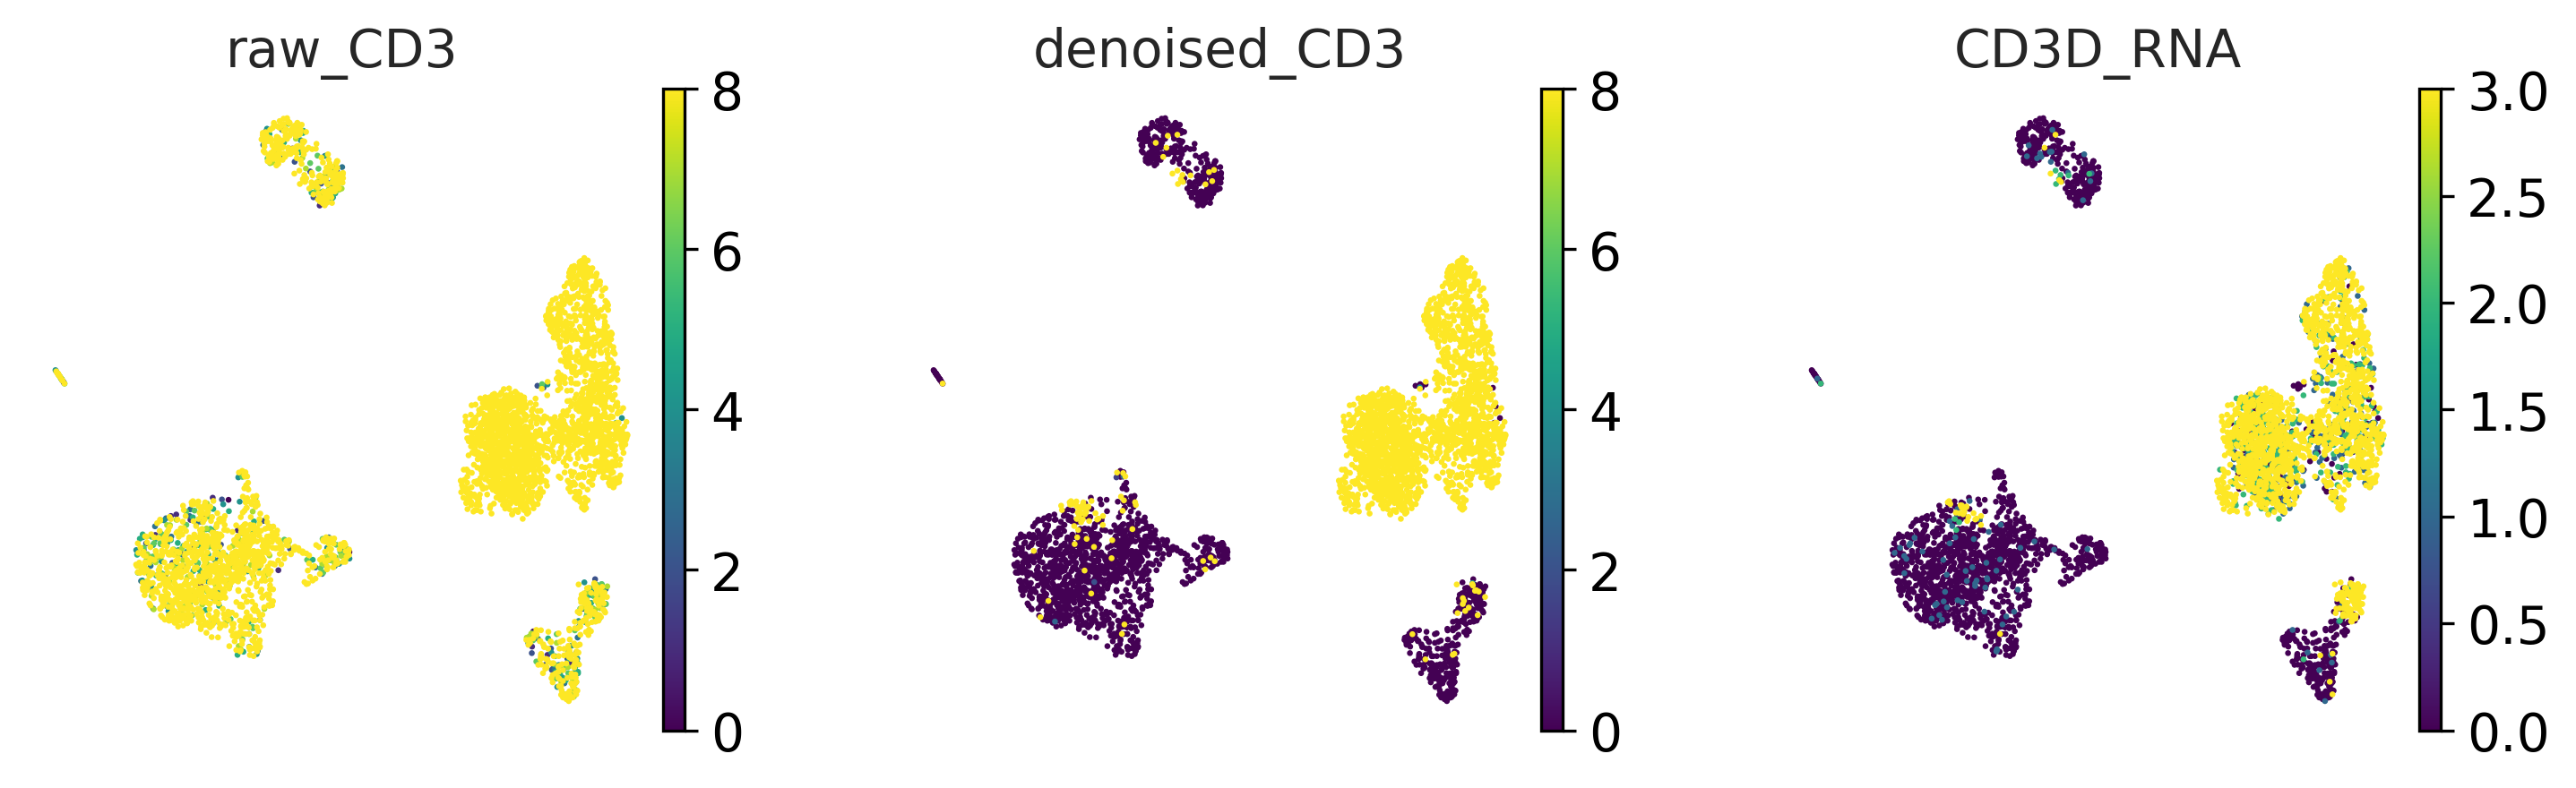

... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


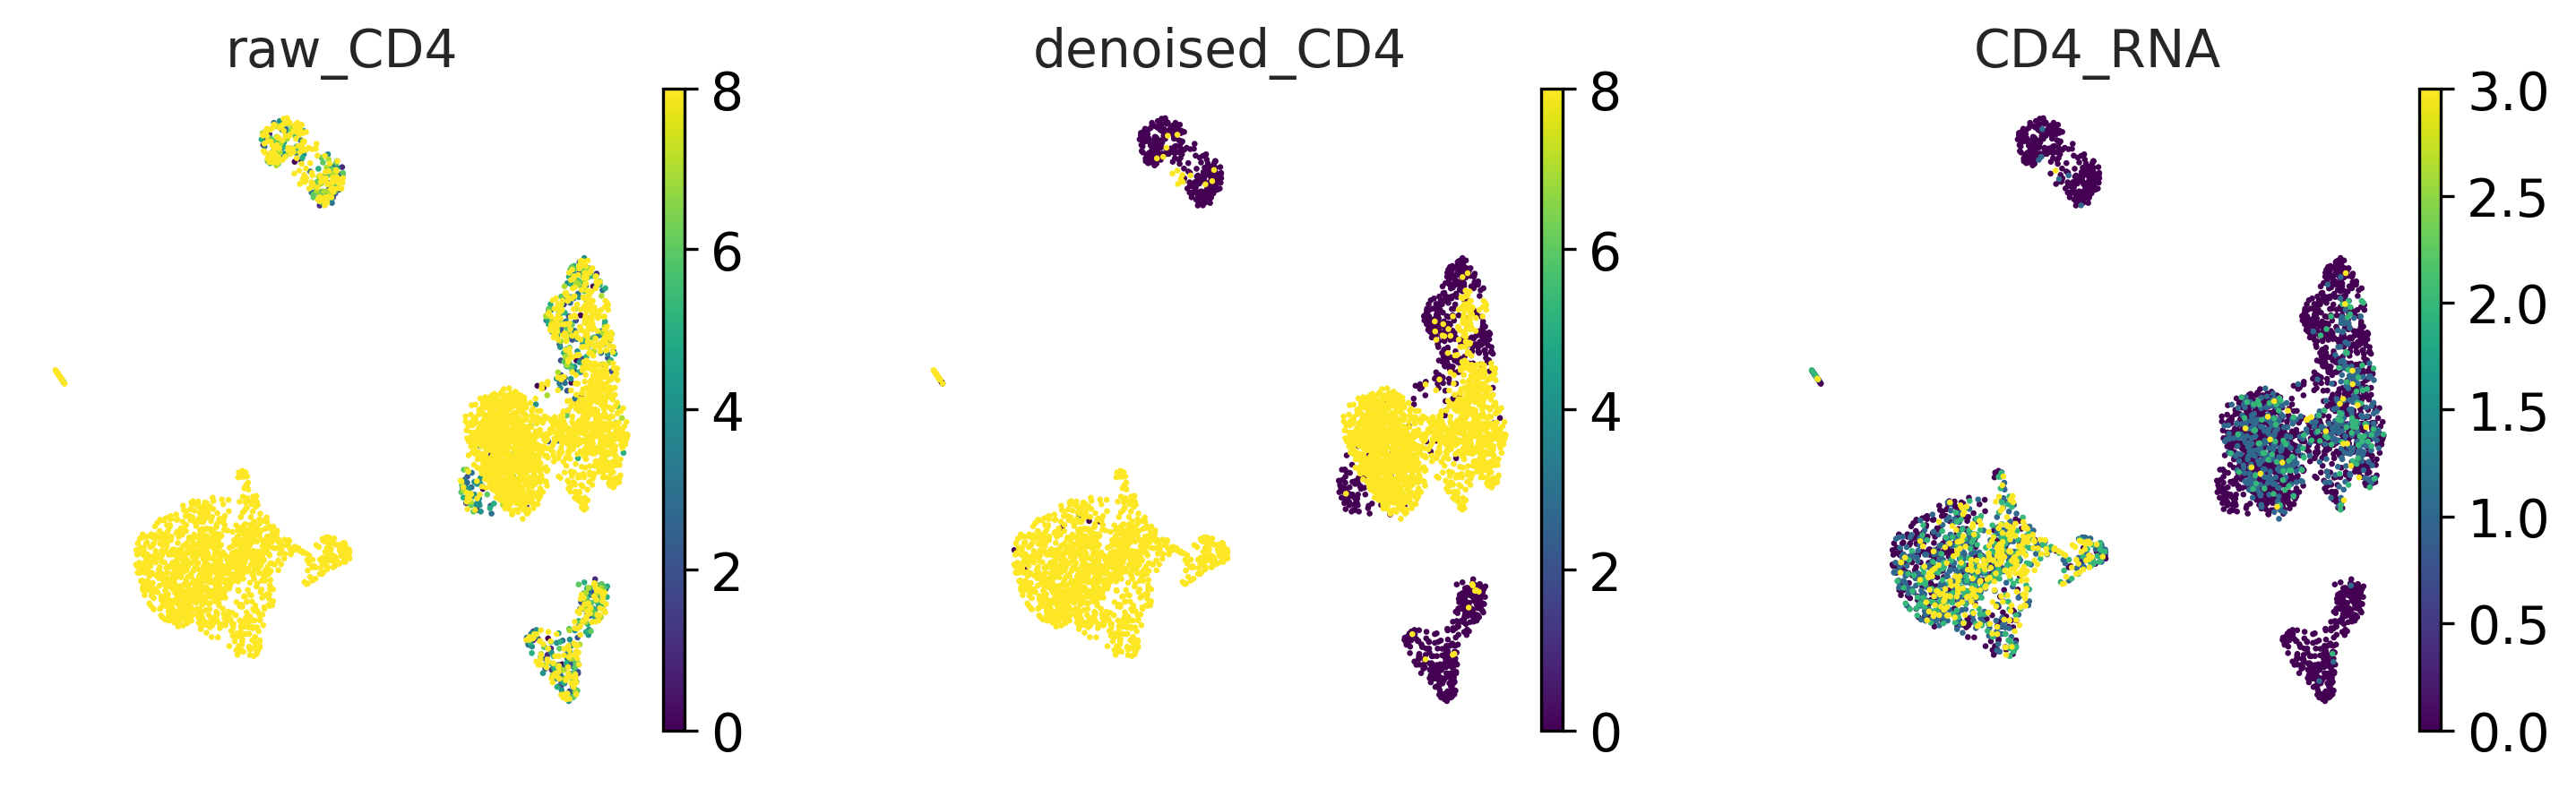

... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


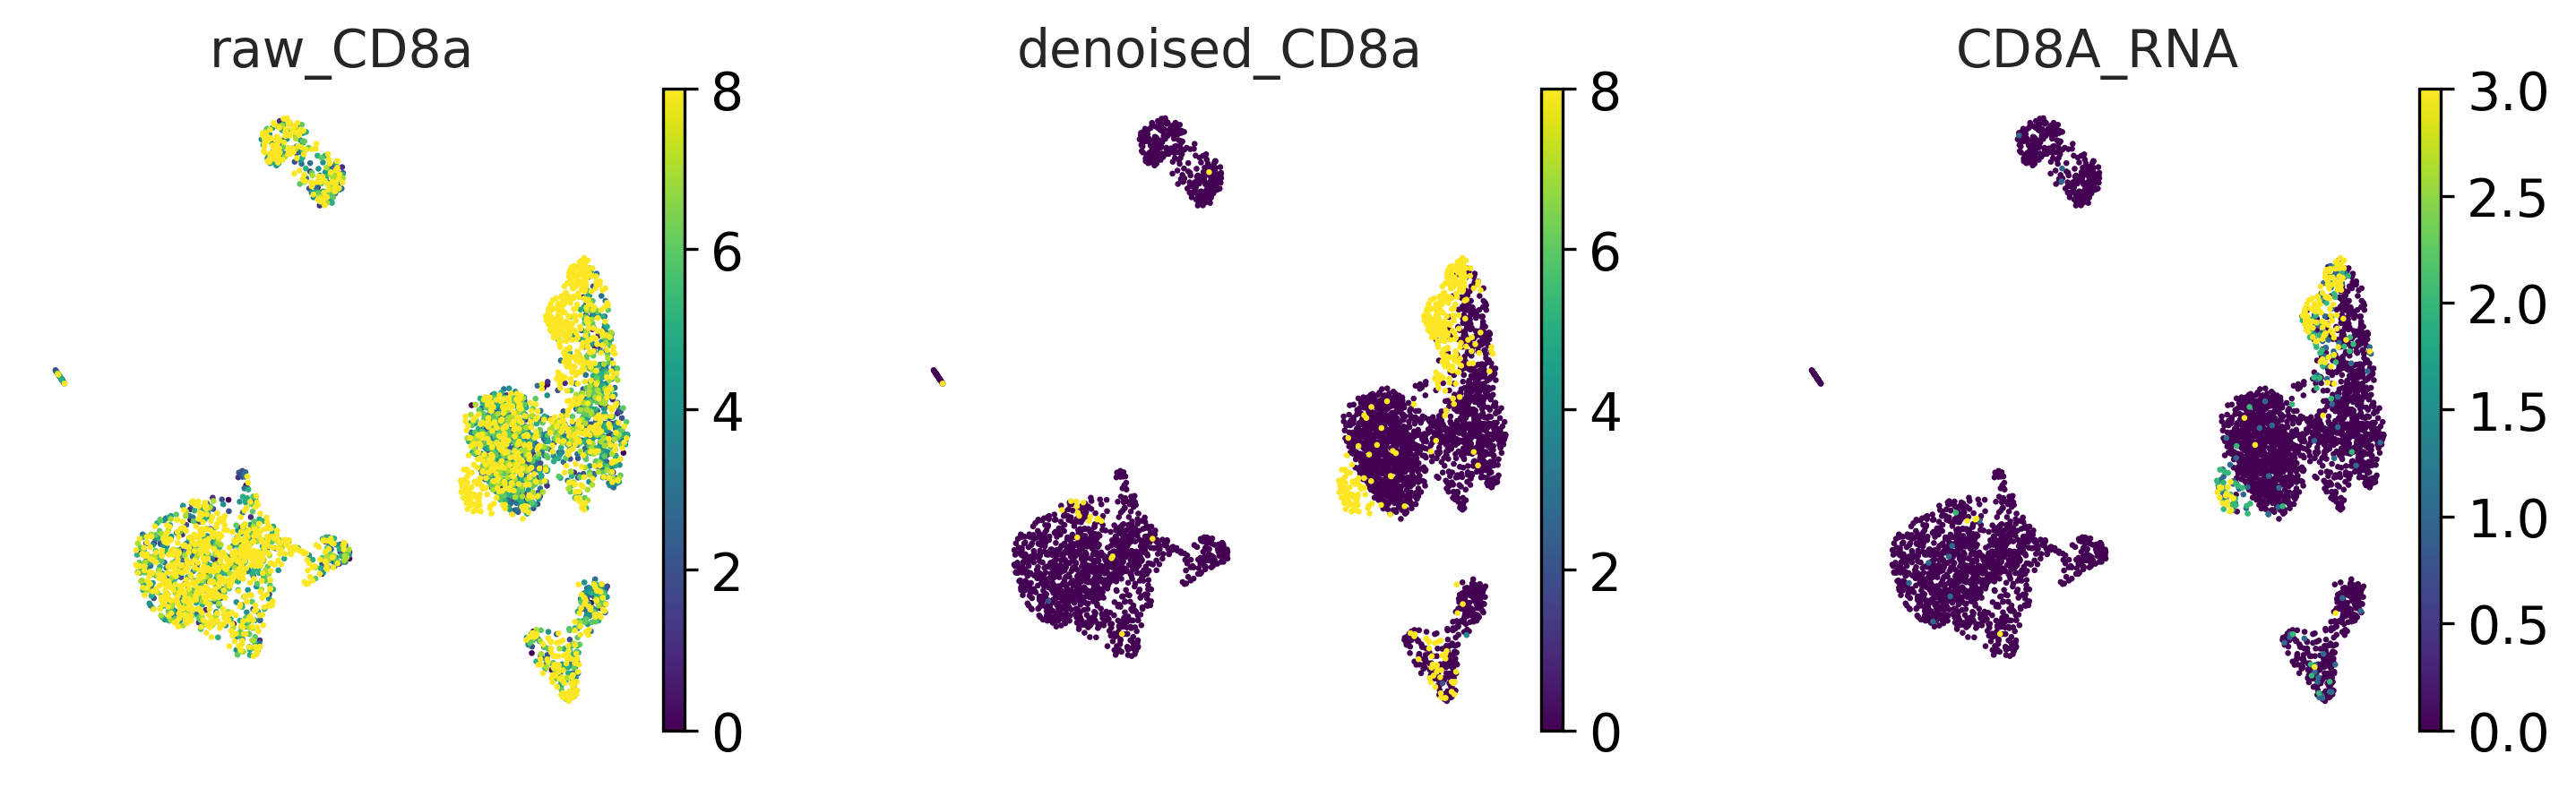

... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


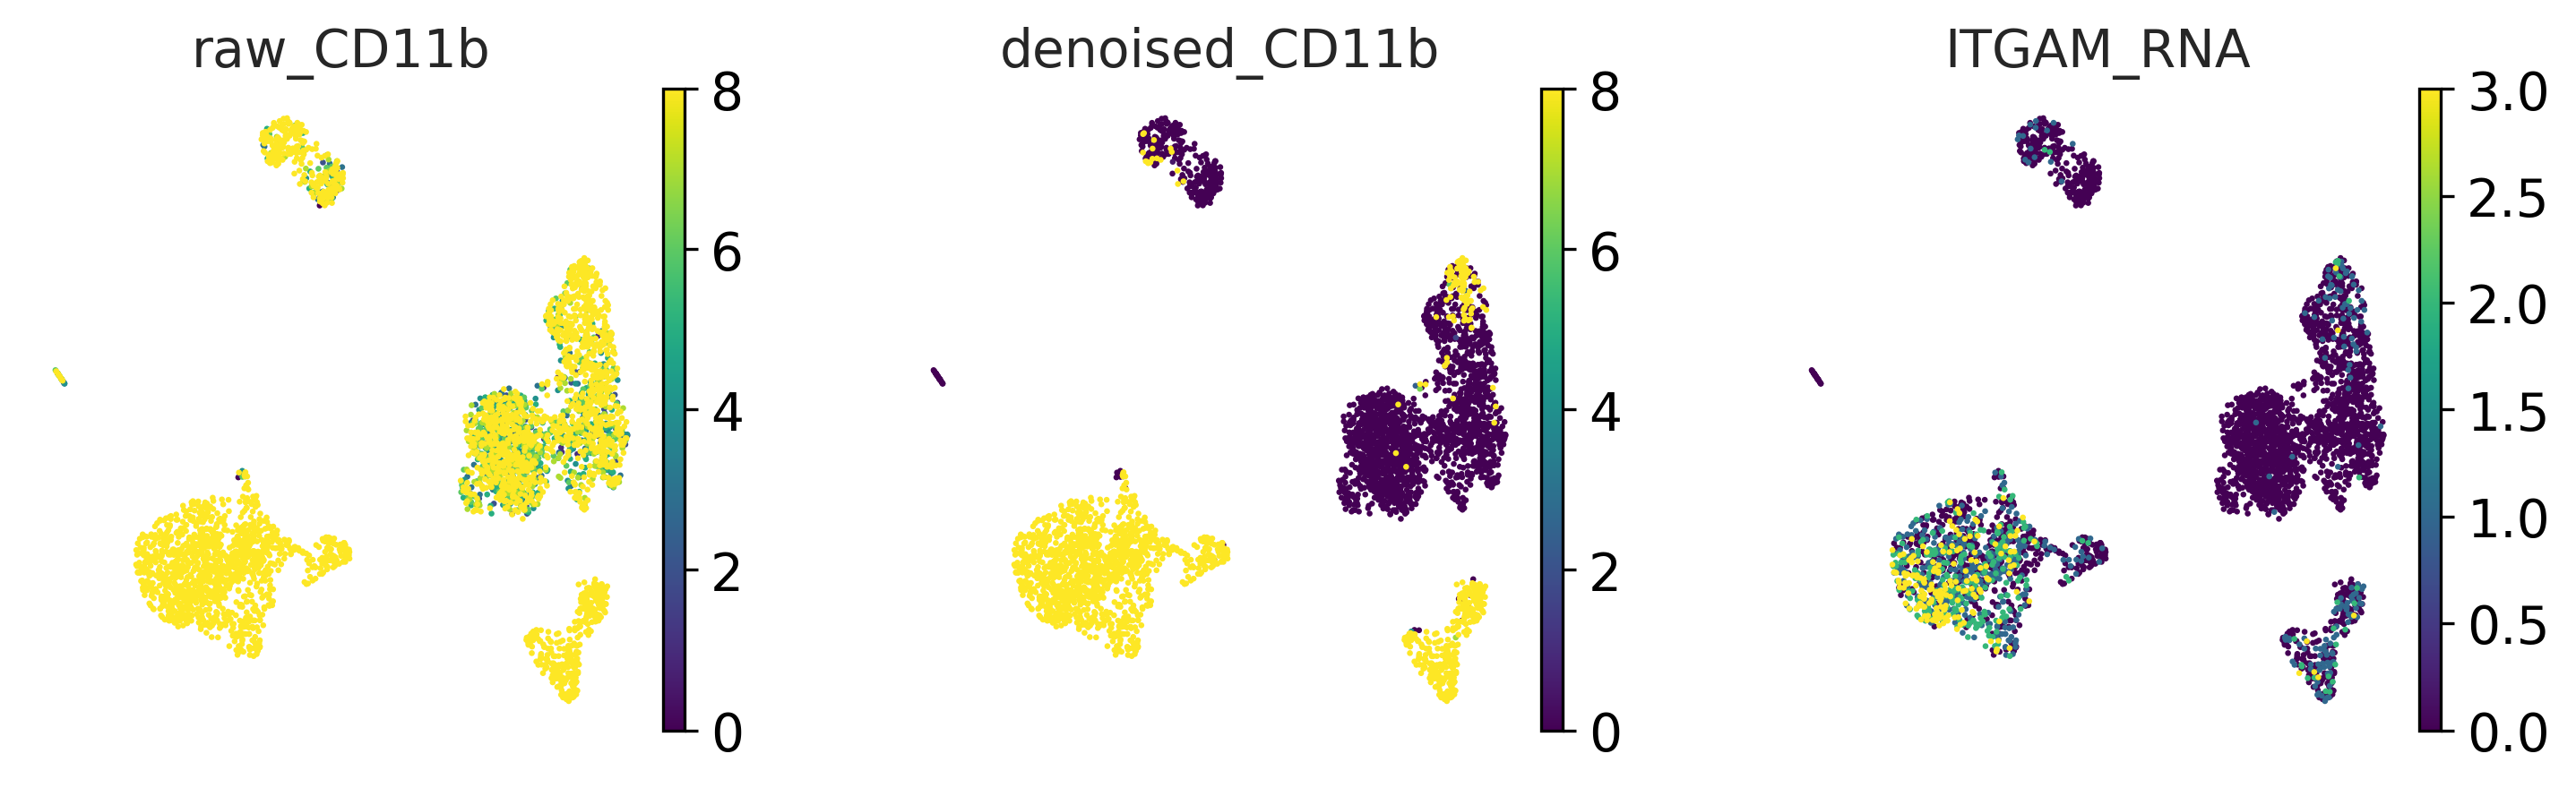

... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


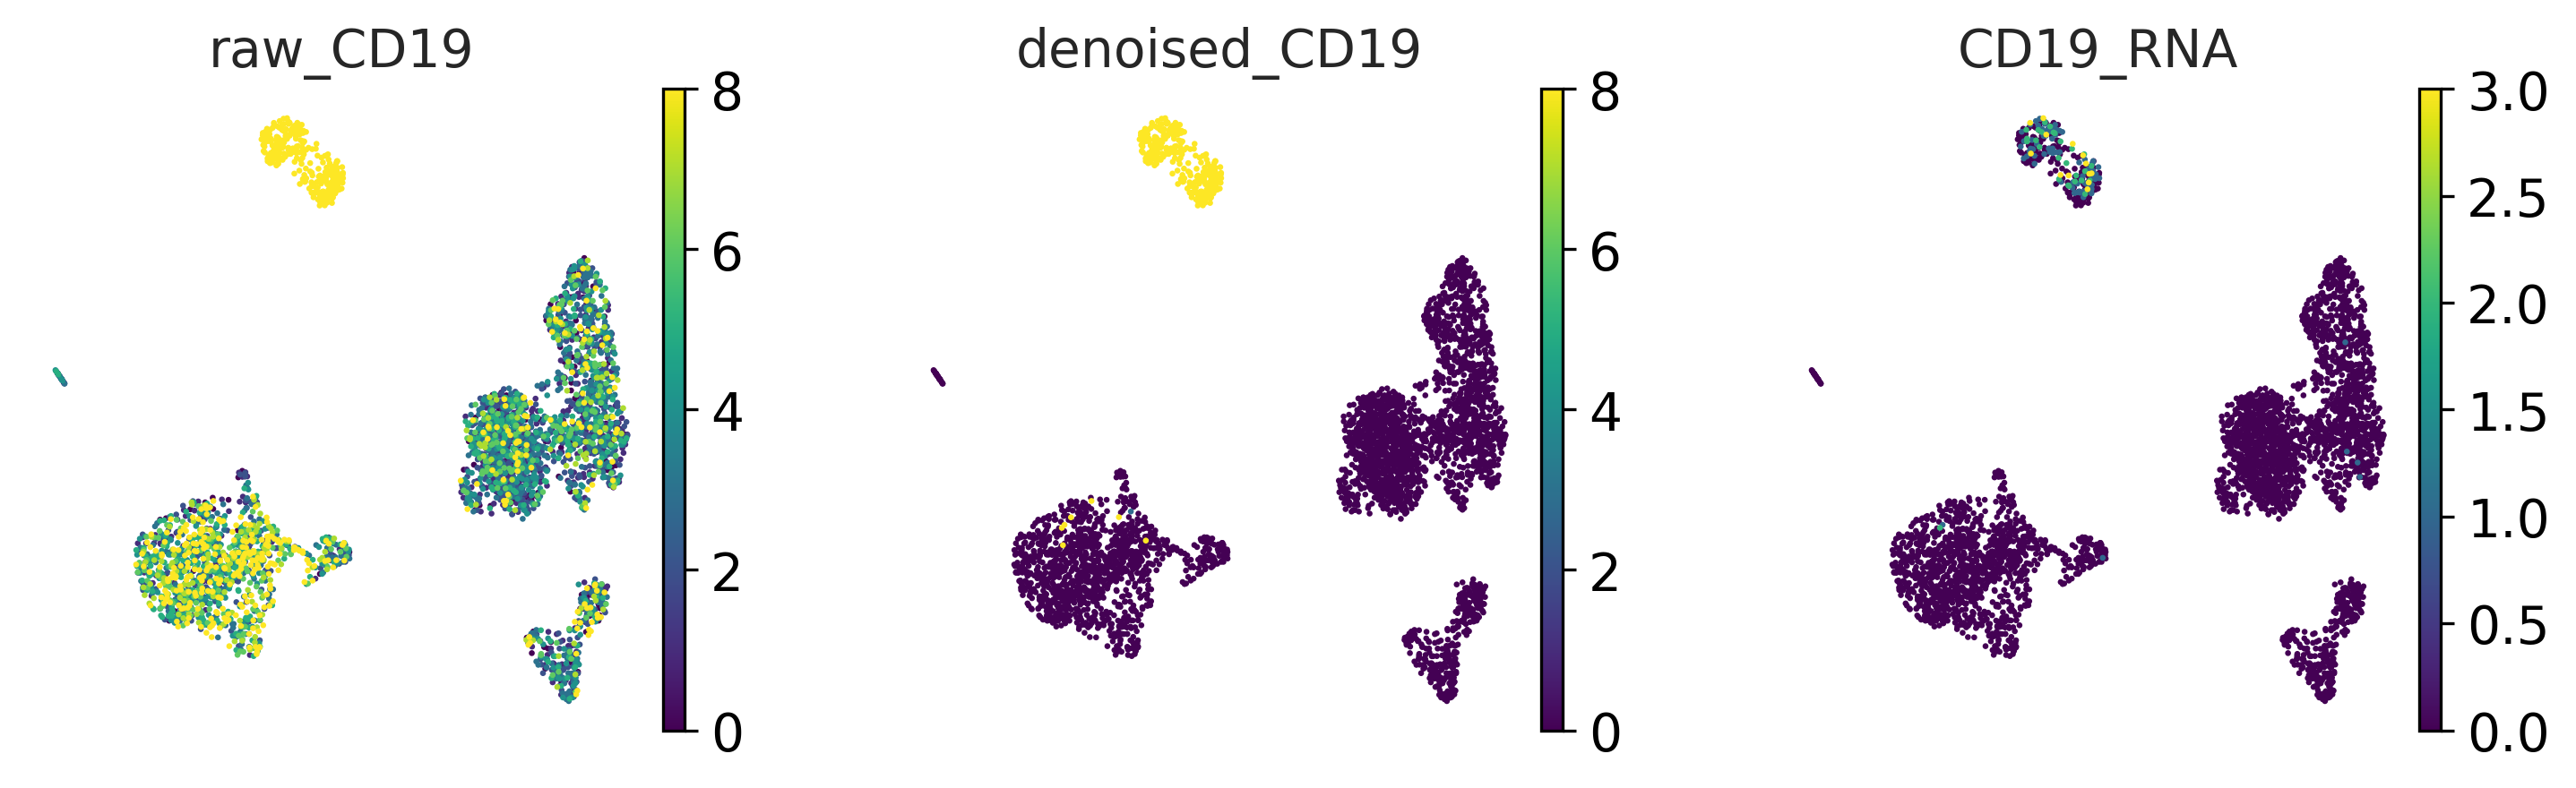

... storing 'PTPRC_RNA' as categorical
... storing 'PTPRC_RNA' as categorical
... storing 'IGHG2_RNA' as categorical
... storing 'IGHG2_RNA' as categorical


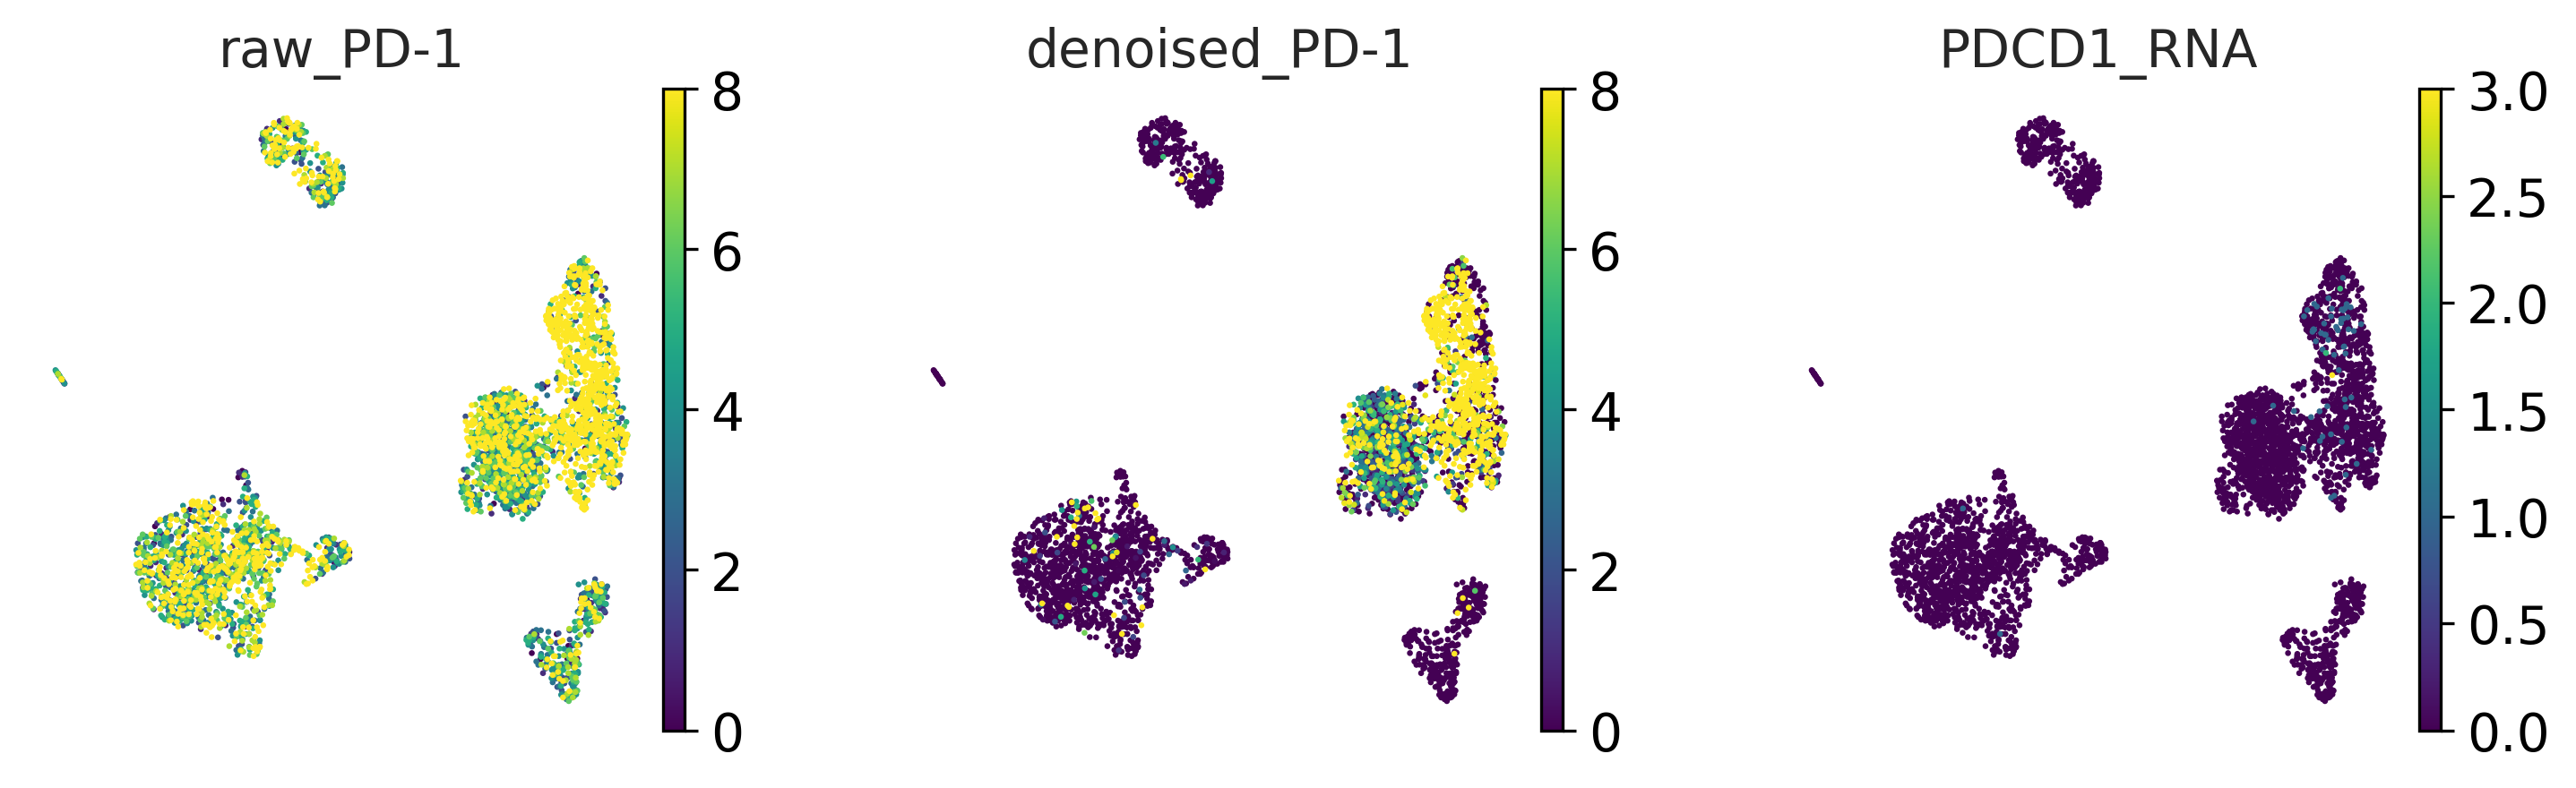

In [16]:
sc.settings.set_figure_params(dpi=150,figsize=(3, 3.1))
for marker in ["CD3", "CD4", "CD8a", "CD11b", "CD19", "PD-1"]:
    raw_prot_label = f'raw_{marker}'
    denoised_prot_label = f'denoised_{marker}'
    RNA_label = f'{prot2gene[marker]}_RNA'
    sc.pl.umap(PBMCs5k,
               size=10,
               color=[raw_prot_label, denoised_prot_label, RNA_label],
               color_map="viridis",
               frameon=False,
               legend_loc="on data",
               legend_fontsize=5,
               vmax=[8, 8, 3],
               vmin=0, )